Processing Corynorhinus townsendii


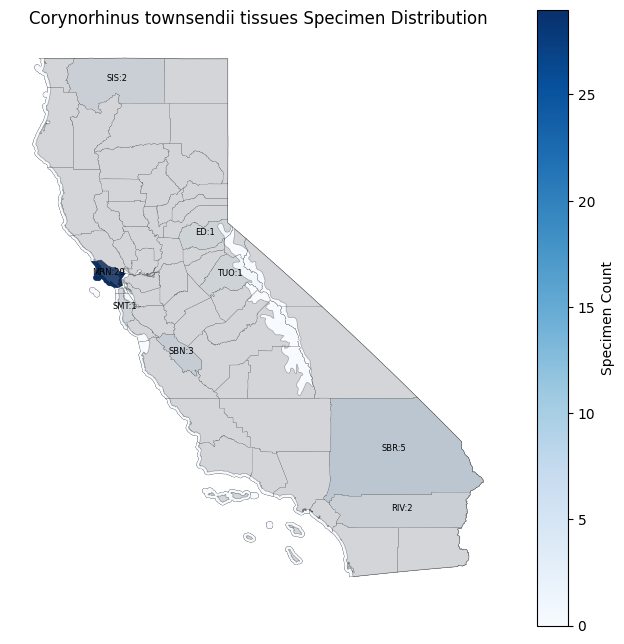

In [4]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd


with open("../data/bats/california_bats.json", "r", encoding="utf8") as in_file:
    ca_bats = json.load(in_file)

with open("../data/counties/ca_county_abbreviations.json", "r", encoding="utf8") as in_file:
    county_abbr = json.load(in_file)

part = "tissues"
species = "Corynorhinus townsendii"

print("Processing", species)

ca_counties = gpd.read_file("../data/counties/ca_counties.geojson")
bat_range = gpd.read_file(f"../data/bats/bat_ranges/{species}.geojson")

mvz_tissues = pd.read_csv(f"../data/bats/mvz_bat_{part}.csv")
mvz_tissues = mvz_tissues[mvz_tissues["species"] == species]
mvz_tissues = mvz_tissues.rename(columns={"county":"namelsad"})
ca_counties = ca_counties.merge(mvz_tissues, how="left", on="namelsad")
ca_counties["specimen_count"] = ca_counties["specimen_count"].fillna(0).astype(int)

if ca_counties["specimen_count"].sum() == 0:
    print("No specimens found, skipping")
else:
    ca_counties = ca_counties.to_crs(bat_range.crs)
    
    first_intersect = ca_counties.intersects(bat_range.loc[0,'geometry'])
    matched = ca_counties[first_intersect]
    
    matched = matched.to_crs(bat_range.crs)
    ax = ca_counties.plot(color='grey', edgecolor="black", linewidth=0.1, figsize=(8,8))
    ax = matched.plot("specimen_count", ax=ax, cmap="Blues", edgecolor="black", linewidth=0.1, legend=True, legend_kwds={"label": "Specimen Count"})
    ax = bat_range.plot(ax=ax, color='grey', alpha=0.3, edgecolor="black", linewidth=0.5)
    
    for idx, row in ca_counties.iterrows():
        if (row["specimen_count"] > 0):
            point = json.loads(row["geo_point_2d"])
            plt.annotate(county_abbr[row["name"]] + ":" + str(row["specimen_count"]), xy=(point["lon"], point["lat"]),
                        horizontalalignment="center", fontsize=6)
    
    ax.set_axis_off()
    ax.set_title(f'{species} {part} Specimen Distribution')
    
    plt.show()